### Resolvendo Equação do Calor Numericamente

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

### Características do Problema

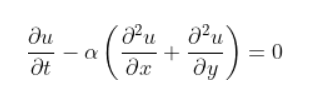

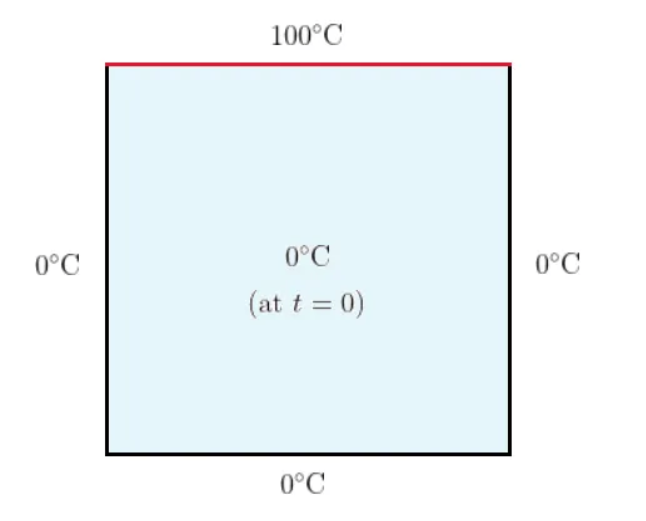

In [26]:
plate_length = 50 #número de pontos da placa
max_iter_time = 250 #número de iterações

alpha = 2 #constante de difusividade
delta_x = 1 #discretização

### Diferenças finitas

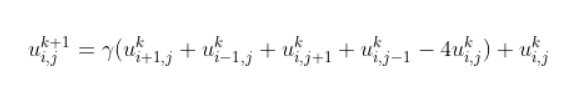

onde gama e delta t precisam valer:

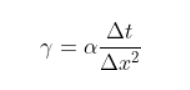

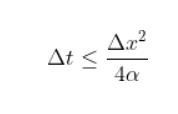

In [27]:
delta_t = (delta_x ** 2)/(4 * alpha)
gamma = (alpha * delta_t) / (delta_x ** 2)

In [28]:
u = np.empty((max_iter_time, plate_length, plate_length)) #inicializando o grid u(k, i, j)

In [29]:
u_initial = 0.0 #condição inicial dentro do grid

In [30]:
# Condições de contorno
u_top = 100.0
u_left = 0.0
u_bottom = 0.0
u_right = 0.0

In [31]:
u.fill(u_initial)

In [32]:
# Configura as condições de contorno
u[:, (plate_length-1):, :] = u_top
u[:, :, :1] = u_left
u[:, :1, 1:] = u_bottom
u[:, :, (plate_length-1):] = u_right

In [33]:
def calculate(u):
  for k in range(0, max_iter_time-1, 1):
    for i in range(1, plate_length-1, delta_x):
      for j in range(1, plate_length-1, delta_x):
        u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]
  
  return u

In [34]:
def plotheatmap(u_k, k):
  # Clear the current plot figure
  plt.clf()
  plt.title(f"Temperature at t = {k*delta_t:.3f} unit time")
  plt.xlabel("x")
  plt.ylabel("y")
  
  # This is to plot u_k (u at time-step k)
  plt.pcolormesh(u_k, cmap=plt.cm.jet, vmin=0, vmax=100)
  plt.colorbar()
  
  return plt

In [35]:
u = calculate(u) #calcula a difusão do calor

MovieWriter ffmpeg unavailable; using Pillow instead.


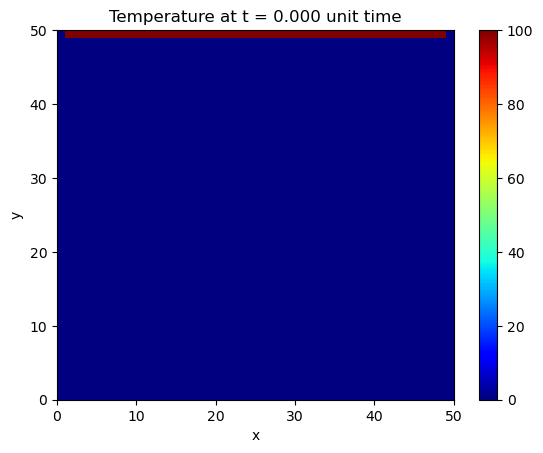

In [36]:
def animate(k):
  plotheatmap(u[k], k)

anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_time, repeat=False)
anim.save("heat_equation_solution.gif")

### Resolvendo Equação do Calor Usando PINN's

In [83]:
import deepxde as dde

In [84]:
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, j=0)
    du_xx = dde.grad.hessian(u, x, j=1)
    du_yy = dde.grad.hessian(u, x, j=2)

    return du_t - alpha * (du_xx + du_yy)

In [85]:
geom = dde.geometry.Rectangle([0, 0], [plate_length, plate_length])

In [86]:
timedomain = dde.geometry.TimeDomain(0, 10) # Resolver essa questão do tempo

In [87]:
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [88]:
def r_boundary(X, on_boundary):
    t, x, y = X
    return on_boundary and np.isclose(x, plate_length)

def l_boundary(X,on_boundary):
    t, x, y = X
    return on_boundary and np.isclose(x,0)

def up_boundary(X,on_boundary):
    t, x, y = X
    return on_boundary and np.isclose(y, plate_length)

def down_boundary(X,on_boundary):
    t, x, y = X
    return on_boundary and np.isclose(y, 0)

def boundary_initial(X, on_initial):
    t, x, y = X
    return on_initial and np.isclose(t, 0)

In [89]:
def func_top(X):
    return u_top * np.ones((len(X),1))

def func_zero(X):
    return np.zeros((len(X),1))

In [90]:
bc_l = dde.DirichletBC(geomtime, func_zero, l_boundary)
bc_r = dde.DirichletBC(geomtime, func_zero, r_boundary)
bc_up = dde.DirichletBC(geomtime, func_top, up_boundary)
bc_low = dde.DirichletBC(geomtime, func_zero, down_boundary)

In [91]:
ic = dde.IC(geomtime, func_zero, lambda _, on_initial: on_initial)

In [92]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_l, bc_r, bc_up, bc_low, ic],
    num_domain=1000,
    num_boundary=1000,
    num_initial=1000,
    num_test=None
)

In [93]:
net = dde.maps.FNN([3] + [60] * 3 + [1], "tanh", "Glorot uniform")
# net.apply_output_transform(lambda x, y: y*100)
model = dde.Model(data, net)

In [94]:
model.compile("adam", lr=1e-3)
model.train(iterations=20000)

Compiling model...
'compile' took 0.000294 s

Training model...



ValueError: (InvalidArgument) Tensor need be reduced must not empty.
  [Hint: Expected input.numel() > 0, but received input.numel():0 <= 0:0.] (at ..\paddle/phi/kernels/funcs/reduce_function.h:1363)
